In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random

In [2]:
#Loading directories
training_dir = r'dataset_updated/training_set'
test_dir = r'dataset_updated/validation_set'

In [3]:
#Loading sub-directories
train_categories = [i for i in os.listdir(training_dir)]
test_categories = [j for j in os.listdir(test_dir)]


In [4]:
train_categories

['drawings', 'engraving', 'iconography', 'painting', 'sculpture']

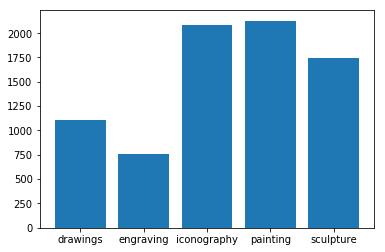

In [5]:
n_imgs = []
for cat in train_categories:
    files = os.listdir(os.path.join(training_dir, cat))
    n_imgs += [len(files)]
    
plt.bar([_ for _ in range(len(train_categories))], n_imgs, tick_label=train_categories)
plt.show()

In [6]:
im_size = 80
training_list = []
test_list = []

In [7]:
#Creating a function to generate training data and test data
def create_data(categories, directory, list_data):
    for category in tqdm(categories):
        path = os.path.join(directory, category)
        class_num = train_categories.index(category)
        for img in os.listdir(path):
            try:
                image_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(image_array, (im_size, im_size))
                list_data.append([new_array, class_num])
            except Exception as e:
                pass
    return list_data

In [8]:
training_data = create_data(train_categories, training_dir, training_list)

100%|████████████████████████████████████████████| 5/5 [01:38<00:00, 18.46s/it]


In [9]:
test_data = create_data(test_categories, test_dir, test_list)

100%|████████████████████████████████████████████| 5/5 [00:08<00:00,  1.84s/it]


In [10]:
random.shuffle(training_data)
random.shuffle(test_data)

In [11]:
X_train_raw = []
X_test_raw = []
y_train_raw = []
y_test_raw = []

In [12]:
#Splitting features and labels for training set
for feature, label in training_data:
    X_train_raw.append(feature)
    y_train_raw.append(label)

In [13]:
#Splitting features and labels for training set
for feature, label in test_data:
    X_test_raw.append(feature)
    y_test_raw.append(label)

In [14]:
#One hot encoding the target variables
y_train = pd.get_dummies(y_train_raw)
y_test = pd.get_dummies(y_test_raw)

In [15]:
#Normalising the variables
X_train = np.array(X_train_raw, np.float32)/255.0
X_test = np.array(X_test_raw, np.float32)/255.0

y_train = np.asarray(y_train, np.int16)
y_test = np.asarray(y_test, np.int16)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7721, 80, 80, 3)
(856, 80, 80, 3)
(7721, 5)
(856, 5)


In [17]:
num_class = y_train.shape[1]

Applying Transfer Learning. Using VGG19 model

In [18]:
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

Using TensorFlow backend.


In [19]:
base_model = VGG19(include_top = False, weights = 'imagenet', #using default imagenet weights
              input_shape = (im_size, im_size, 3))

#Add a new top layer
x = base_model.output
x = Flatten()(x)

x = Dense(128, activation = 'relu')(x)

predictions = Dense(num_class, activation = 'softmax')(x)


model = Model(inputs = base_model.input, outputs = predictions)

#Freezing the trainable layers
for layer in base_model.layers:
    layer.trainable = False
    
#Compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience = 3, verbose = 1)]
model.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0         
__________

Due to low computation, I'm running only 3 epochs.

In [20]:
#Fitting the model
history = model.fit(X_train, y_train, epochs = 3, validation_data = (X_test, y_test), verbose = 1)

Train on 7721 samples, validate on 856 samples
Epoch 1/3


6496/7721 [========================>.....] - ETA: 39:51 - loss: 2.2640 - acc: 0.06 - ETA: 31:43 - loss: 1.9245 - acc: 0.18 - ETA: 27:06 - loss: 1.8405 - acc: 0.29 - ETA: 24:53 - loss: 1.7609 - acc: 0.34 - ETA: 23:34 - loss: 1.6720 - acc: 0.38 - ETA: 22:44 - loss: 1.6216 - acc: 0.39 - ETA: 22:10 - loss: 1.5656 - acc: 0.43 - ETA: 21:44 - loss: 1.4536 - acc: 0.48 - ETA: 21:25 - loss: 1.4303 - acc: 0.48 - ETA: 21:10 - loss: 1.3897 - acc: 0.49 - ETA: 20:57 - loss: 1.3585 - acc: 0.50 - ETA: 20:46 - loss: 1.3163 - acc: 0.52 - ETA: 20:37 - loss: 1.2666 - acc: 0.55 - ETA: 20:30 - loss: 1.2276 - acc: 0.56 - ETA: 20:22 - loss: 1.2299 - acc: 0.56 - ETA: 20:15 - loss: 1.1988 - acc: 0.57 - ETA: 20:09 - loss: 1.1869 - acc: 0.57 - ETA: 20:02 - loss: 1.1691 - acc: 0.58 - ETA: 19:56 - loss: 1.1542 - acc: 0.58 - ETA: 19:50 - loss: 1.1309 - acc: 0.59 - ETA: 19:45 - loss: 1.1122 - acc: 0.60 - ETA: 19:39 - loss: 1.0880 - acc: 0.60 - ETA: 19:33 - loss: 1.0673 - acc: 0.61 - ETA: 19:28 - loss: 1.0602 - acc: 0.

6528/7721 [========================>.....] - ETA: 22:01 - loss: 0.4242 - acc: 0.81 - ETA: 21:54 - loss: 0.3757 - acc: 0.84 - ETA: 21:50 - loss: 0.3705 - acc: 0.84 - ETA: 21:43 - loss: 0.3650 - acc: 0.83 - ETA: 21:39 - loss: 0.3965 - acc: 0.83 - ETA: 21:34 - loss: 0.4033 - acc: 0.84 - ETA: 21:30 - loss: 0.3856 - acc: 0.85 - ETA: 21:24 - loss: 0.3701 - acc: 0.85 - ETA: 21:18 - loss: 0.3950 - acc: 0.84 - ETA: 21:14 - loss: 0.3737 - acc: 0.85 - ETA: 21:08 - loss: 0.3828 - acc: 0.84 - ETA: 21:02 - loss: 0.3900 - acc: 0.84 - ETA: 20:57 - loss: 0.4050 - acc: 0.84 - ETA: 20:52 - loss: 0.4011 - acc: 0.84 - ETA: 20:49 - loss: 0.3949 - acc: 0.84 - ETA: 20:43 - loss: 0.3996 - acc: 0.84 - ETA: 20:38 - loss: 0.4226 - acc: 0.83 - ETA: 20:33 - loss: 0.4114 - acc: 0.84 - ETA: 20:28 - loss: 0.4035 - acc: 0.84 - ETA: 20:22 - loss: 0.4061 - acc: 0.84 - ETA: 20:17 - loss: 0.4141 - acc: 0.84 - ETA: 20:11 - loss: 0.4058 - acc: 0.84 - ETA: 20:05 - loss: 0.4016 - acc: 0.84 - ETA: 19:59 - loss: 0.4005 - acc: 0.

7721/7721 [==============================] - ETA: 3:23 - loss: 0.3727 - acc: 0.861 - ETA: 3:17 - loss: 0.3721 - acc: 0.861 - ETA: 3:12 - loss: 0.3713 - acc: 0.861 - ETA: 3:06 - loss: 0.3709 - acc: 0.862 - ETA: 3:00 - loss: 0.3707 - acc: 0.862 - ETA: 2:55 - loss: 0.3715 - acc: 0.861 - ETA: 2:49 - loss: 0.3705 - acc: 0.862 - ETA: 2:43 - loss: 0.3706 - acc: 0.862 - ETA: 2:38 - loss: 0.3699 - acc: 0.862 - ETA: 2:32 - loss: 0.3703 - acc: 0.862 - ETA: 2:27 - loss: 0.3702 - acc: 0.862 - ETA: 2:21 - loss: 0.3705 - acc: 0.862 - ETA: 2:15 - loss: 0.3702 - acc: 0.862 - ETA: 2:10 - loss: 0.3700 - acc: 0.862 - ETA: 2:04 - loss: 0.3702 - acc: 0.862 - ETA: 1:59 - loss: 0.3696 - acc: 0.862 - ETA: 1:53 - loss: 0.3697 - acc: 0.862 - ETA: 1:47 - loss: 0.3706 - acc: 0.862 - ETA: 1:42 - loss: 0.3706 - acc: 0.862 - ETA: 1:36 - loss: 0.3702 - acc: 0.862 - ETA: 1:31 - loss: 0.3705 - acc: 0.862 - ETA: 1:25 - loss: 0.3700 - acc: 0.862 - ETA: 1:19 - loss: 0.3695 - acc: 0.863 - ETA: 1:14 - loss: 0.3695 - acc: 0.8

6528/7721 [========================>.....] - ETA: 22:05 - loss: 0.2177 - acc: 0.90 - ETA: 22:05 - loss: 0.3243 - acc: 0.87 - ETA: 22:01 - loss: 0.2761 - acc: 0.90 - ETA: 21:55 - loss: 0.2871 - acc: 0.89 - ETA: 21:50 - loss: 0.2730 - acc: 0.90 - ETA: 21:46 - loss: 0.2827 - acc: 0.89 - ETA: 21:44 - loss: 0.2673 - acc: 0.90 - ETA: 21:38 - loss: 0.2532 - acc: 0.90 - ETA: 21:37 - loss: 0.2503 - acc: 0.90 - ETA: 21:34 - loss: 0.2478 - acc: 0.90 - ETA: 21:27 - loss: 0.2497 - acc: 0.90 - ETA: 21:19 - loss: 0.2555 - acc: 0.90 - ETA: 21:13 - loss: 0.2553 - acc: 0.90 - ETA: 21:06 - loss: 0.2498 - acc: 0.90 - ETA: 21:06 - loss: 0.2505 - acc: 0.90 - ETA: 21:19 - loss: 0.2488 - acc: 0.90 - ETA: 21:21 - loss: 0.2418 - acc: 0.90 - ETA: 21:29 - loss: 0.2390 - acc: 0.90 - ETA: 21:30 - loss: 0.2433 - acc: 0.90 - ETA: 21:25 - loss: 0.2596 - acc: 0.90 - ETA: 21:27 - loss: 0.2629 - acc: 0.90 - ETA: 21:35 - loss: 0.2610 - acc: 0.90 - ETA: 21:29 - loss: 0.2666 - acc: 0.89 - ETA: 21:21 - loss: 0.2727 - acc: 0.

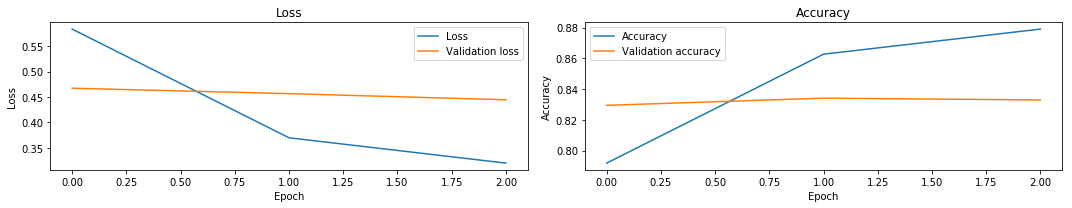

In [21]:
#Visualizing the results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(history.history['loss'], label="Loss")
axes[0].plot(history.history['val_loss'], label="Validation loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()


axes[1].plot(history.history['acc'], label="Accuracy")
axes[1].plot(history.history['val_acc'], label="Validation accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()